In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
import pickle
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, log_loss, confusion_matrix, f1_score, balanced_accuracy_score, accuracy_score, roc_curve, auc

In [110]:
X_true_test_df = pd.read_csv("test_processed.csv", index_col=0)
train_df = pd.read_csv("train_processed.csv", index_col=0)

Y_train_df = train_df["target"]
X_train_df = train_df.drop("target", axis=1)

In [111]:
# X_true_test_df = X_true_test_df[:2000]
# Y_train_df = Y_train_df[:2000]
# X_train_df = X_train_df[:2000]

In [112]:
X_train = X_train_df.values
Y_train = Y_train_df.values
X_true_test = X_true_test_df.values

In [113]:
print(X_train.shape, X_true_test.shape)

(137599, 103) (129950, 103)


# Feature Selection

In [50]:
def standarize(df):
    return (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))


def boruta_feature_selection(x, y):
    rfc = RandomForestClassifier(n_estimators=200,
                                 n_jobs=-1,
                                 class_weight='balanced',
                                 max_depth=7,
                                 random_state=0)
    boruta_selector = BorutaPy(rfc,
                               n_estimators='auto',
                               verbose=1,
                               random_state=0)
    boruta_selector.fit(x, y)
    features = np.where(boruta_selector.support_ +
                        boruta_selector.support_weak_ == True)[0]
    print(f"\rBoruta\nNumber of Selected Features: {features.shape[0]}")
    print("Selected Features: ")
    print(*features.tolist(), sep=", ")
    return features.tolist()


def calculate_r_2_for_feature(data, feature, regression_type):
    new_data = data.drop(feature, axis=1)

    X_train, \
    X_test,  \
    y_train, \
    y_test = train_test_split(
        new_data,data[feature],test_size=0.25
    )
    if regression_type == "KNR":
        regressor = KNeighborsRegressor()
    elif regression_type == "DTR":
        regressor = DecisionTreeRegressor()
    else:
        raise Exception("Wrong type of regression, use:\n",
                        "KNR for KNeighborsRegressor\n",
                        "DTR for DecisionTreeRegressor")
    regressor.fit(X_train, y_train)

    # score returns the coefficient of determination R^2 of the prediction.
    score = regressor.score(X_test, y_test)
    return score


def calculate_mean_r_2(data, feature, regression_type, iteration=10):
    scores = []
    for i in range(iteration):
        scores.append(calculate_r_2_for_feature(data, feature,
                                                regression_type))
    scores = np.array(scores)
    return scores.mean()


def r_2_score_denoisser(X_train, regression_type="KNR"):
    x_df = pd.DataFrame(X_train)
    avg_r2_feature_scores = []
    for column in tqdm(x_df.columns):
        score = calculate_mean_r_2(x_df.sample(n=30, random_state=1), column,
                                   regression_type)
        avg_r2_feature_scores.append(score)

    features = [i for i, r2 in enumerate(avg_r2_feature_scores) if r2 > 0]
    print("R\u00b2 Score Denoisser\nRegressor:", end=" ")
    if regression_type == "KNR":
        print("KNeighborsRegressor")
    elif regression_type == "DTR":
        print("DecisionTreeRegressor")
    print(f"Number of Selected Features: {len(features)}")
    print("Selected Feaures: ")
    print(*features, sep=", ")
    return features

In [51]:
features_DTR = r_2_score_denoisser(X_train, regression_type="DTR")


R² Score Denoisser
Regressor: DecisionTreeRegressor
Number of Selected Features: 71
Selected Feaures: 
1, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 84, 87, 88, 89, 102


In [52]:
features_KNR = r_2_score_denoisser(X_train, regression_type="KNR")


R² Score Denoisser
Regressor: KNeighborsRegressor
Number of Selected Features: 68
Selected Feaures: 
1, 7, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 87, 89, 90, 98, 102


In [53]:
features_boruta = boruta_feature_selection(X_train, Y_train)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100


BorutaPy finished running.

Iteration: 	20 / 100
Confirmed: 	16
Tentative: 	0
Rejected: 	87
Boruta
Number of Selected Features: 16
Selected Features: 
0, 1, 2, 3, 4, 13, 14, 27, 29, 37, 40, 63, 75, 77, 101, 102


In [54]:
features_all = range(103)

In [13]:
# x_train, x_test, y_train, y_test = train_test_split(X_train[:, features],Y_train,test_size=0.3)

## PCA

In [41]:
def pca_decomp(X_train, Y_train, X_true_test):
    X_train = StandardScaler().fit_transform(X_train)
    pca = PCA(n_components=0.9, svd_solver='full', random_state=0).fit(X_train)
    X_train = pca.transform(X_train)
    X_true_test = pca.transform(X_true_test)
    print(len(pca.components_))
    x_train, x_test, y_train, y_test = train_test_split(X_train,
                                                        Y_train,
                                                        test_size=0.3)
    return (x_train, x_test, y_train, y_test, X_true_test)


x_train, x_test, y_train, y_test, x_true_test = pca_decomp(
    X_train, Y_train, X_true_test)

68


TypeError: '(slice(None, None, None), 0)' is an invalid key

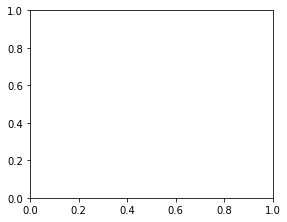

In [107]:
fig = plt.figure(figsize=(20, 20))
col_names = X_train_df.iloc[:, features].columns
for i in range(16):
    fig.add_subplot(5, 4, i + 1)
    plt.hist(x_train[:, i])
    plt.title(f"{col_names[i]}")

In [44]:
print("Unbalanced set with %.2f of true labales" % y_train.mean())

Unbalanced set with 0.17 of true labales


# Logistic Regression

In [51]:
logregPipe = Pipeline([('logreg', LogisticRegression(random_state=123))])
_ = logregPipe.fit(x_train, y_train)

In [52]:
print('f1_score on the tain set: ',
      f1_score(y_train, logregPipe.predict(x_train)))
print('f1_score on the test set: ', f1_score(y_test,
                                             logregPipe.predict(x_test)))

f1_score on the tain set:  0.0
f1_score on the test set:  0.0


           selected parameter
logreg__C            0.051795


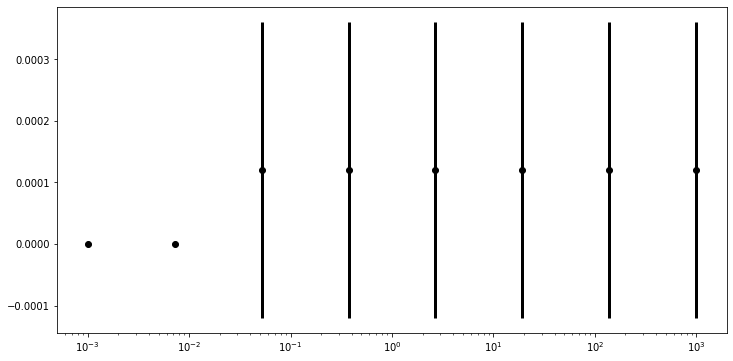

In [53]:
param_space = np.logspace(-3, 3, 8)
logregParam = {'logreg__C': param_space}
logregGS = GridSearchCV(estimator=logregPipe,
                        param_grid=logregParam,
                        cv=5,
                        scoring='f1').fit(x_train, y_train)
print(
    pd.DataFrame.from_dict(logregGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = logregGS.cv_results_["mean_test_score"]
std_test_score = logregGS.cv_results_["std_test_score"]
plt.figure(figsize=(12, 6))
plt.errorbar(param_space, mean_test_score, std_test_score, fmt='ok', lw=3)
plt.xscale('log')

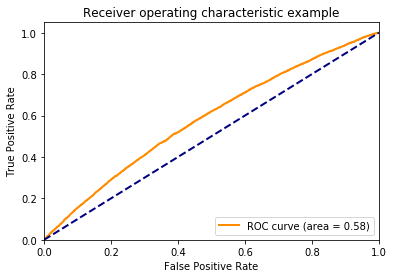

In [54]:
def roc_curve_plot(clf, x_train, y_train, x_test, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_score = clf.fit(x_train, y_train).decision_function(x_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr,
             tpr,
             color='darkorange',
             lw=lw,
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


roc_curve_plot(logregGS, x_train, y_train, x_test, y_test)

In [55]:
print("f1_score on the test set: ", f1_score(y_train,
                                             logregGS.predict(x_train)))
print("f1_score on the train set: ", f1_score(y_test,
                                              logregGS.predict(x_test)))

f1_score on the test set:  0.0
f1_score on the train set:  0.0


In [56]:
logregGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, logregGS.predict(x_test)), columns=['Predicted 0', 'Predicted 1'],\
                                index=['Actual 0', 'Actual 1'])
logregGS_confMatrix

,Predicted 0,Predicted 1
Actual 0,34269,1
Actual 1,7010,0


# KNeighborsClassifier

In [38]:
knnPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs=-1)),
])
knnParam = {
    'knn__n_neighbors': range(1, 12),
    'knn__weights': ['uniform', 'distance'],
}
_ = knnPipe.fit(x_train, y_train)

In [41]:
print('f1_score on the train set: ', f1_score(y_train,
                                              knnPipe.predict(x_train)))
print('f1_score on the test set: ', f1_score(y_test, knnPipe.predict(x_test)))

f1_score on the train set:  0.06611570247933884
f1_score on the test set:  0.02777777777777778


                 selected parameter
knn__n_neighbors                  1
knn__weights                uniform


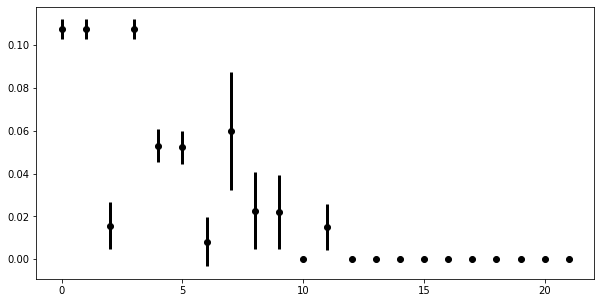

In [42]:
knnGS = GridSearchCV(knnPipe, param_grid=knnParam, n_jobs=-1, scoring='f1')
_ = knnGS.fit(x_train, y_train)
print(
    pd.DataFrame.from_dict(knnGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = knnGS.cv_results_["mean_test_score"]
std_test_score = knnGS.cv_results_["std_test_score"]
plt.figure(figsize=(10, 5))
_ = plt.errorbar(np.arange(mean_test_score.shape[0]),
                 mean_test_score,
                 std_test_score,
                 fmt='ok',
                 lw=3)

In [43]:
print("f1_score on the train set: ", f1_score(y_train, knnGS.predict(x_train)))
print("f1_score on the test set:", f1_score(y_test, knnGS.predict(x_test)))

f1_score on the train set:  1.0
f1_score on the test set: 0.1021897810218978


In [44]:
knnGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, knnGS.predict(x_test)), \
                                columns=['Predicted 0', 'Predicted 1'], \
                                index=['Actual 0', 'Actual 1'])
knnGS_confMatrix

,Predicted 0,Predicted 1
Actual 0,370,69
Actual 1,54,7


# DecisionTree Classifier

In [18]:
dectreePipe = Pipeline([('scaler', StandardScaler()),
                        ('dectree', DecisionTreeClassifier(random_state=123))])
dectreeParam = {
    'dectree__criterion': ['entropy'],
    'dectree__class_weight': ['balanced'],
    'dectree__max_depth': range(1, 7),
}

                      selected parameter
dectree__class_weight           balanced
dectree__criterion               entropy
dectree__max_depth                     3


<ErrorbarContainer object of 3 artists>

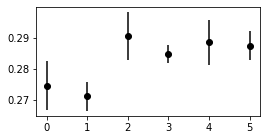

In [19]:
dectreeGS = GridSearchCV(dectreePipe,
                         param_grid=dectreeParam,
                         cv=5,
                         scoring='f1')
_ = dectreeGS.fit(x_train, y_train)
print(
    pd.DataFrame.from_dict(dectreeGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = dectreeGS.cv_results_["mean_test_score"]
std_test_score = dectreeGS.cv_results_["std_test_score"]
plt.figure(figsize=(4, 2))
plt.errorbar(np.arange(mean_test_score.shape[0]),
             mean_test_score,
             std_test_score,
             fmt='ok')

In [20]:
print("f1_score on the train set: ",
      f1_score(y_train, dectreeGS.predict(x_train)))
print("f1_score on the test set:", f1_score(y_test, dectreeGS.predict(x_test)))

f1_score on the train set:  0.29786029203575615
f1_score on the test set: 0.2920367870931291


In [21]:
pd.DataFrame(confusion_matrix(y_test, dectreeGS.predict(x_test)),
             columns=['Predicted -1', 'Predicted 1'],
             index=['Actual 0', 'Actual 1'])

,Predicted -1,Predicted 1
Actual 0,14073,20092
Actual 1,2463,4652


# Random Forest

In [94]:
class_weight = dict({0.0: 9, 1.0: 1})
randtreePipe = Pipeline([('scaler', StandardScaler()),
                         ('randtree',
                          RandomForestClassifier(random_state=123,
                                                 n_estimators=100,
                                                 max_depth=15,
                                                 class_weight=None))])

randtreeParam = {
    'randtree__bootstrap': [True],
    'randtree__max_depth': [20],
    'randtree__max_features': ['auto', 'sqrt'],
    'randtree__min_samples_leaf': [1, 2, 4],
    'randtree__min_samples_split': [2, 5, 10],
}

# randtree__bootstrap                       True
# randtree__max_depth                         20
# randtree__max_features                    auto
# randtree__min_samples_leaf                   1
# randtree__min_samples_split                  2

                            selected parameter
randtree__bootstrap                       True
randtree__max_depth                         20
randtree__max_features                    auto
randtree__min_samples_leaf                   1
randtree__min_samples_split                  2


<ErrorbarContainer object of 3 artists>

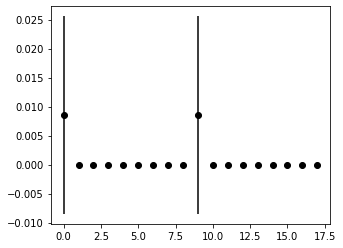

In [95]:
randtreeGS = GridSearchCV(randtreePipe,
                          param_grid=randtreeParam,
                          cv=5,
                          scoring='f1')
randtreeGS.fit(x_train, y_train)
mean_test_score = randtreeGS.cv_results_["mean_test_score"]

std_test_score = randtreeGS.cv_results_["std_test_score"]

print(
    pd.DataFrame.from_dict(randtreeGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))

# pd.DataFrame(randtreeGS.cv_results_).sort_values(by='rank_test_score')[:5][[
#     'rank_test_score', 'param_randtree__max_depth', 'mean_test_score',
#     'std_test_score'
# ]].T

plt.figure(figsize=(5, 4))
plt.errorbar(np.arange(mean_test_score.shape[0]),
             mean_test_score,
             std_test_score,
             fmt='ok')

In [96]:
print("f1_score on the train set: ",
      f1_score(y_train, randtreeGS.predict(x_train)))
print("f1_score on the test set:", f1_score(y_test,
                                            randtreeGS.predict(x_test)))

f1_score on the train set:  0.9699769053117783
f1_score on the test set: 0.0


In [97]:
randtreeGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, randtreeGS.predict(x_test)), columns=['Predicted 0', \
                                                                                               'Predicted 1'],\
                                   index=['Actual 0', 'Actual 1'])
randtreeGS_confMatrix

,Predicted 0,Predicted 1
Actual 0,439,0
Actual 1,61,0


# XGBoost

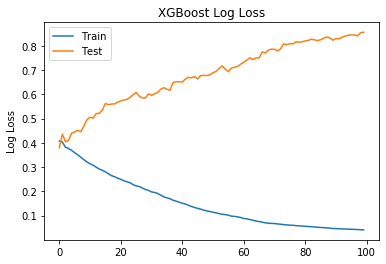

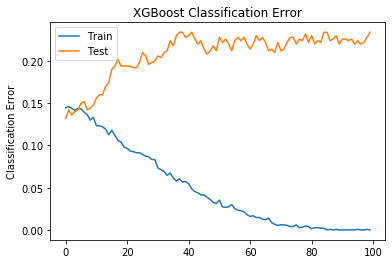

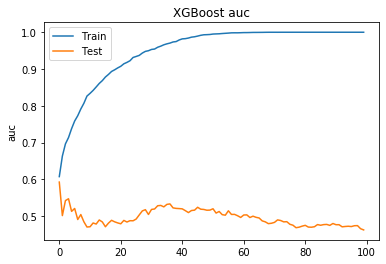

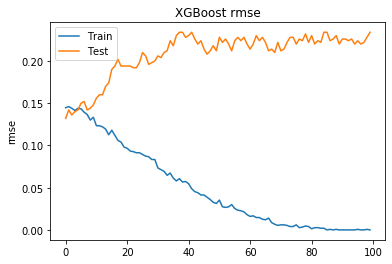

In [102]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=1.5)
eval_set = [(x_train, y_train), (x_test, y_test)]
xgb.fit(x_train,
        y_train,
        eval_metric=["error", "logloss", "auc", "rmse"],
        eval_set=eval_set,
        verbose=False)
pd.DataFrame(confusion_matrix(y_test, xgb.predict(x_test)),
             columns=['Predicted 0', 'Predicted 1'],
             index=['Actual 0', 'Actual 1'])

results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.title('XGBoost auc')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()

In [103]:
confMatrix = pd.DataFrame(confusion_matrix(y_test, xgb.predict(x_test)),
                          columns=['Predicted 0', 'Predicted 1'],
                          index=['Actual 0', 'Actual 1'])
confMatrix

,Predicted 0,Predicted 1
Actual 0,380,59
Actual 1,58,3


In [107]:
f1_scores = cross_val_score(xgb, x_train, y_train, cv=5, scoring='f1')
print("F1-score = ", f1_scores, " Mean F1 score = ", np.mean(f1_scores))

F1-score =  [0.12820513 0.19444444 0.15789474 0.10810811 0.18666667]  Mean F1 score =  0.15506381685329054


In [114]:
def xg_f1(t, y):
    #     t = t.get_label()
    y_bin = [1. if y_cont > 0.5 else 0.
             for y_cont in y]  # binaryzing your output
    return f1_score(t, y_bin)


xg_f1(y_test, xgb.predict(x_test))

0.04878048780487805

In [116]:
print("Logistic Regression")
print("f1_score on the train set: ", logregGS.score(x_train, y_train))
print("f1_score on the test set: ", logregGS.score(x_test, y_test))

print("\nK-Neighbors Classifier")
print("f1_score on the train set: ", knnGS.score(x_train, y_train))
print("f1_score on the test set:", knnGS.score(x_test, y_test))

print("\nDecision Tree Classifier")
print('f1_score on the train set: ', dectreeGS.score(x_train, y_train))
print('f1_score on the test set: ', dectreeGS.score(x_test, y_test))

print("\nRandomForestClassifier")
print("f1_score on the train set", randtreeGS.score(x_train, y_train))
print("f1_score on the test set", randtreeGS.score(x_test, y_test))

print("\nXGBoost")
print("f1_score on the train set", xg_f1(y_train, xgb.predict(x_train)))
print("f1_score on the test set", xg_f1(y_test, xgb.predict(x_test)))

Logistic Regression
f1_score on the train set:  0.02654867256637168
f1_score on the test set:  0.0

K-Neighbors Classifier
f1_score on the train set:  1.0
f1_score on the test set: 0.1021897810218978

Decision Tree Classifier
f1_score on the train set:  0.2913907284768212
f1_score on the test set:  0.27927927927927926

RandomForestClassifier
f1_score on the train set 0.9699769053117783
f1_score on the test set 0.0

XGBoost
f1_score on the train set 1.0
f1_score on the test set 0.04878048780487805


# Testing DTC with PCA

In [55]:
x_train, x_test, y_train, y_test, x_true_test = pca_decomp(
    X_train, Y_train, X_true_test)

68


In [56]:
dectreePipe = Pipeline([('scaler', StandardScaler()),
                        ('dectree', DecisionTreeClassifier(random_state=123))])
dectreeParam = {
    'dectree__criterion': ['entropy'],
    'dectree__class_weight': ['balanced'],
    'dectree__max_depth': range(1, 7),
}
# _ = dectreePipe.fit(x_train, y_train)

                      selected parameter
dectree__class_weight           balanced
dectree__criterion               entropy
dectree__max_depth                     5


<ErrorbarContainer object of 3 artists>

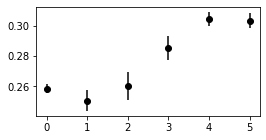

In [57]:
dectreeGS = GridSearchCV(dectreePipe,
                         param_grid=dectreeParam,
                         cv=5,
                         scoring='f1')
_ = dectreeGS.fit(x_train, y_train)
print(
    pd.DataFrame.from_dict(dectreeGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = dectreeGS.cv_results_["mean_test_score"]
std_test_score = dectreeGS.cv_results_["std_test_score"]
plt.figure(figsize=(4, 2))
plt.errorbar(np.arange(mean_test_score.shape[0]),
             mean_test_score,
             std_test_score,
             fmt='ok')

In [58]:
print("f1_score on the train set: ",
      f1_score(y_train, dectreeGS.predict(x_train)))
print("f1_score on the test set:", f1_score(y_test, dectreeGS.predict(x_test)))

f1_score on the train set:  0.31313708999158957
f1_score on the test set: 0.3080059593821062


In [59]:
pd.DataFrame(confusion_matrix(y_test, dectreeGS.predict(x_test)),
             columns=['Predicted -1', 'Predicted 1'],
             index=['Actual 0', 'Actual 1'])

,Predicted -1,Predicted 1
Actual 0,19702,14515
Actual 1,3135,3928


# Testing DTC with feature selection

In [62]:
print("\nDecision Tree Clasifier")
for features_name, features in {
        'features_KNR': features_KNR,
        'features_DTR': features_DTR,
        'features_boruta': features_boruta,
        'all': features_all
}.items():
    print("\t", features_name, len(features))
    x_sel = X_train_df.iloc[:, features]
    x_val_sel = X_train_df.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,
                                                        Y_train,
                                                        test_size=0.25)

    dectreePipe = Pipeline([('scaler', StandardScaler()),
                            ('dectree',
                             DecisionTreeClassifier(random_state=123,
                                                    class_weight='balanced',
                                                    criterion='entropy'))])
    dectreeParam = {
        'dectree__max_depth': range(1, 20),
    }
    dectreeGS = GridSearchCV(dectreePipe,
                             param_grid=dectreeParam,
                             cv=5,
                             scoring="f1")
    _ = dectreeGS.fit(x_train, y_train)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)

    cv_train = cross_val_score(dectreeGS,
                               x_train,
                               y_train,
                               cv=skf,
                               scoring="f1")
    cv_test = cross_val_score(dectreeGS, x_test, y_test, cv=skf, scoring="f1")

    print("\t\tCV f1 on the train set: ", (cv_train.mean() * 100).round(2),"%")
    print("\t\tCV f1 on the test set:", (cv_test.mean() * 100).round(2), "%")


Decision Tree Clasifier
	 features_KNR 68
		CV f1 on the train set:  31.04 %
		CV f1 on the test set: 30.75 %
	 features_DTR 71
		CV f1 on the train set:  30.81 %
		CV f1 on the test set: 31.2 %
	 features_boruta 16
		CV f1 on the train set:  34.59 %
		CV f1 on the test set: 33.8 %
	 all 103
		CV f1 on the train set:  34.19 %
		CV f1 on the test set: 34.17 %


# Final Result

As a result none of our feature selection technique performed better than whole features set.

# Final Training

In [83]:
print("All features", len(features))
features = features_all
x_sel = X_train_df.iloc[:, features]
x_val_sel = X_train_df.iloc[:, features]
x_train, y_train = x_sel, Y_train
x_test = X_true_test
for i in [x_train, x_test, y_train]:
    print(i.shape)

All features 103
(137599, 103)
(129950, 103)
(137599,)


In [94]:
dectreePipe = Pipeline([('scaler', StandardScaler()),
                        ('dectree',
                         DecisionTreeClassifier(random_state=123,
                                                class_weight='balanced',
                                                criterion='entropy',
                                                max_depth = 5))], 
                         verbose=True)

_ = dectreePipe.fit(x_train, y_train)

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(x_train, y_train)

cv_train = cross_val_score(dectreeGS,
                           x_train,
                           y_train,
                           cv=skf,
                           scoring="f1")

print("CV f1 on the train set: ", (cv_train.mean() * 100).round(2),"%")


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ........... (step 2 of 2) Processing dectree, total=   0.8s
		CV f1 on the train set:  33.21 %


# Pickling

In [95]:
type(dectreePipe)

sklearn.pipeline.Pipeline

In [96]:
filename = 'dectreePipe.pickle'
pickle.dump(dectreePipe, open(filename, 'wb'))

In [99]:
x_test.shape

(129950, 103)

In [115]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_train, X_train)
print("F1-score on test set", result)

F1-score on test set 0.6143140575149528


# Output File Saving

In [116]:
save_data = loaded_model.predict_proba(x_val_sel)[:, 1]
np.savetxt("output.csv", save_data, delimiter="", fmt='%f', header="prediction")

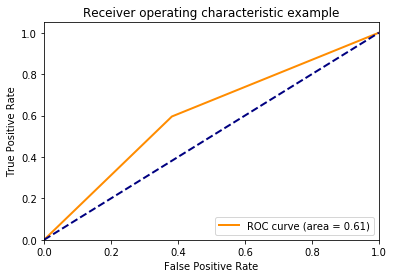

In [122]:
fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = loaded_model.predict(X_train)



fpr, tpr, _ = roc_curve(Y_train, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr,
         tpr,
         color='darkorange',
         lw=lw,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_score = loaded_model.predict(X_true_test_df)
pd.read_csv("test.csv").shape
ids = pd.read_csv("test.csv")["accident_id"]
preds = pd.concat([pd.DataFrame(ids, columns=["accident_id"]), pd.DataFrame(y_score, columns=["prediction"], dtype=int)], axis=1)
preds.astype(int)
preds.to_csv("test_preds.csv", index=False)
pd.read_csv("accidents.csv")[["accident_id", "target"]].to_csv("golden_standard.csv", index=False)